# The code 
The code in this notebook is originally developed by Ennova-Research, without the use of licensed code.
It can be downloaded from the GitHub repository `https://github.com/ennova-research/2023_GCP_Specialization_Demo_2-Black_Friday`

# The data
The data come from the link provided in the "Machine Learning - Services Specialization" guidebook. 
The link refers to the kaggle page `https://www.kaggle.com/abhisingh10p14/black-friday`, where we can download the "Black Friday dataset". 
In the link there are 2 files: "train.csv" and "test.csv". Since "test.csv" doesn't have the column "Purchase" (that is the dependent variable in our study), we won't use the file.
The file "train.csv", renamed as "data_raw.csv", has been uploaded on Google Cloud Storage in a specific project (Project_Name: "ML Spec",Project_ID: "ml-spec", gsutil_URI: `gs://engo-ml_spec2023-demo2/data_raw.csv`).

# Goal and solution
The goal of the study is to increase profits and our solution is to identify the users' categories that spend more, the products' categories more profitable and a combination of the two (the most profitable products' categories for each users' category), such that a targeted advertising campaign could be conduct.

# Data exploration (EDA)

In [ ]:
import sys
sys.path.append('..')

In [1]:

# Loading useful libraries

import numpy as np
import pandas as pd

import optuna
import random

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, PrecisionRecallDisplay, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder


import Demo2

In [2]:
# Getting dataset from CS

# data = pd.read_csv('gs://engo-ml_spec2023-demo2/data_raw.csv')
# data.head()

In [3]:
# Getting dataset from local file

data = pd.read_csv('../data/train.csv')
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Let's divide "data" in "df" (train) and "test". To make this division as indipendent and representative as possible, we need for each "User_ID" to have all its information in just one side and the User_IDs needs to be balanced in charcteristics across the sets. We decided to ignore the characteristics "Occupation", "Stay_In_Current_City_Years" and "Marital_Status" since keeping them would mean to segment the dataset too much, with groups with too little units, and we kept "Gender", "Age", "City_Category" and "Marital_Status"
Also, to assert that the study is exactly repeatable, we need to set a seed for the random generator.

In [4]:
seed = 42

users=pd.DataFrame()
users['Gender'] = data.groupby('User_ID').agg({'Gender': 'first'})
users['Age'] = data.groupby('User_ID').agg({'Age': 'first'})
users['Occupation'] = data.groupby('User_ID').agg({'Occupation': 'first'})
users['City_Category'] = data.groupby('User_ID').agg({'City_Category': 'first'})
users['Stay_In_Current_City_Years'] = data.groupby('User_ID').agg({'Stay_In_Current_City_Years': 'first'})
users['Marital_Status'] = data.groupby('User_ID').agg({'Marital_Status': 'first'})
users['Number of Purchases'] = data.groupby('User_ID').size()
users['Sum spent'] = data.groupby('User_ID')['Purchase'].sum()
users['Average Purchase'] = data.groupby('User_ID')['Purchase'].mean()

users_train, users_test = train_test_split(users, test_size=.2, random_state=seed, stratify=users[['Gender', 'Age', 'City_Category', 'Marital_Status']])

df = deepcopy(data)[data['User_ID'].isin(users_train.index)]
df_test = deepcopy(data)[data['User_ID'].isin(users_test.index)]

In [5]:
# Checking data shape

df.shape

(441907, 12)

In [6]:
# Checking data types

df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [7]:
# Checking data for missing values

df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            139509
Product_Category_3            307974
Purchase                           0
dtype: int64

In [8]:
# Filling missing values in data 

df[['Product_Category_2', 'Product_Category_3']] = df[['Product_Category_2', 'Product_Category_3']].fillna(-1).astype(int)

In [9]:
# Checking data for duplicates

df.duplicated().sum()

0

In [10]:
# Checking unique values in data columns

df.nunique()

User_ID                        4712
Product_ID                     3596
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               18
Product_Category_3               16
Purchase                      17675
dtype: int64

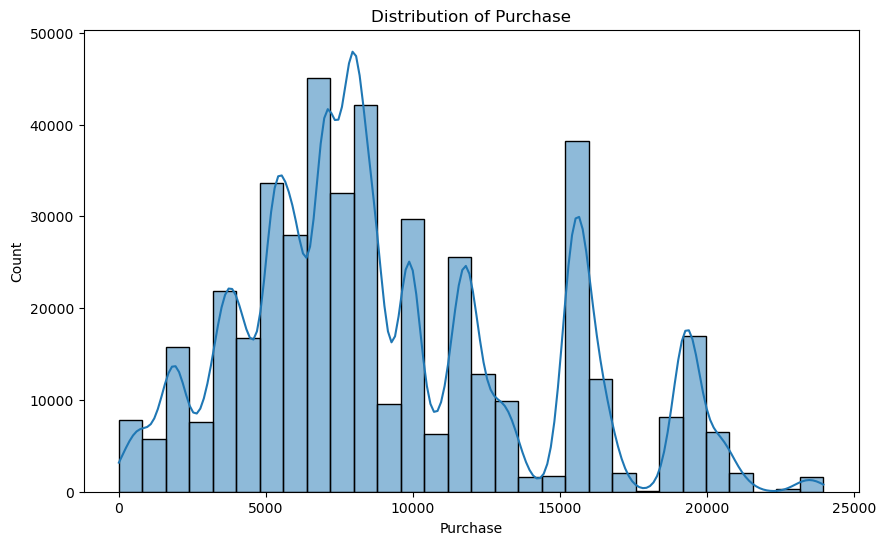

In [11]:
# Plotting "Purchase" distribution

plt.figure(figsize=(10, 6))
sns.histplot(df['Purchase'], bins=30, kde=True)
plt.title('Distribution of Purchase')
plt.show()

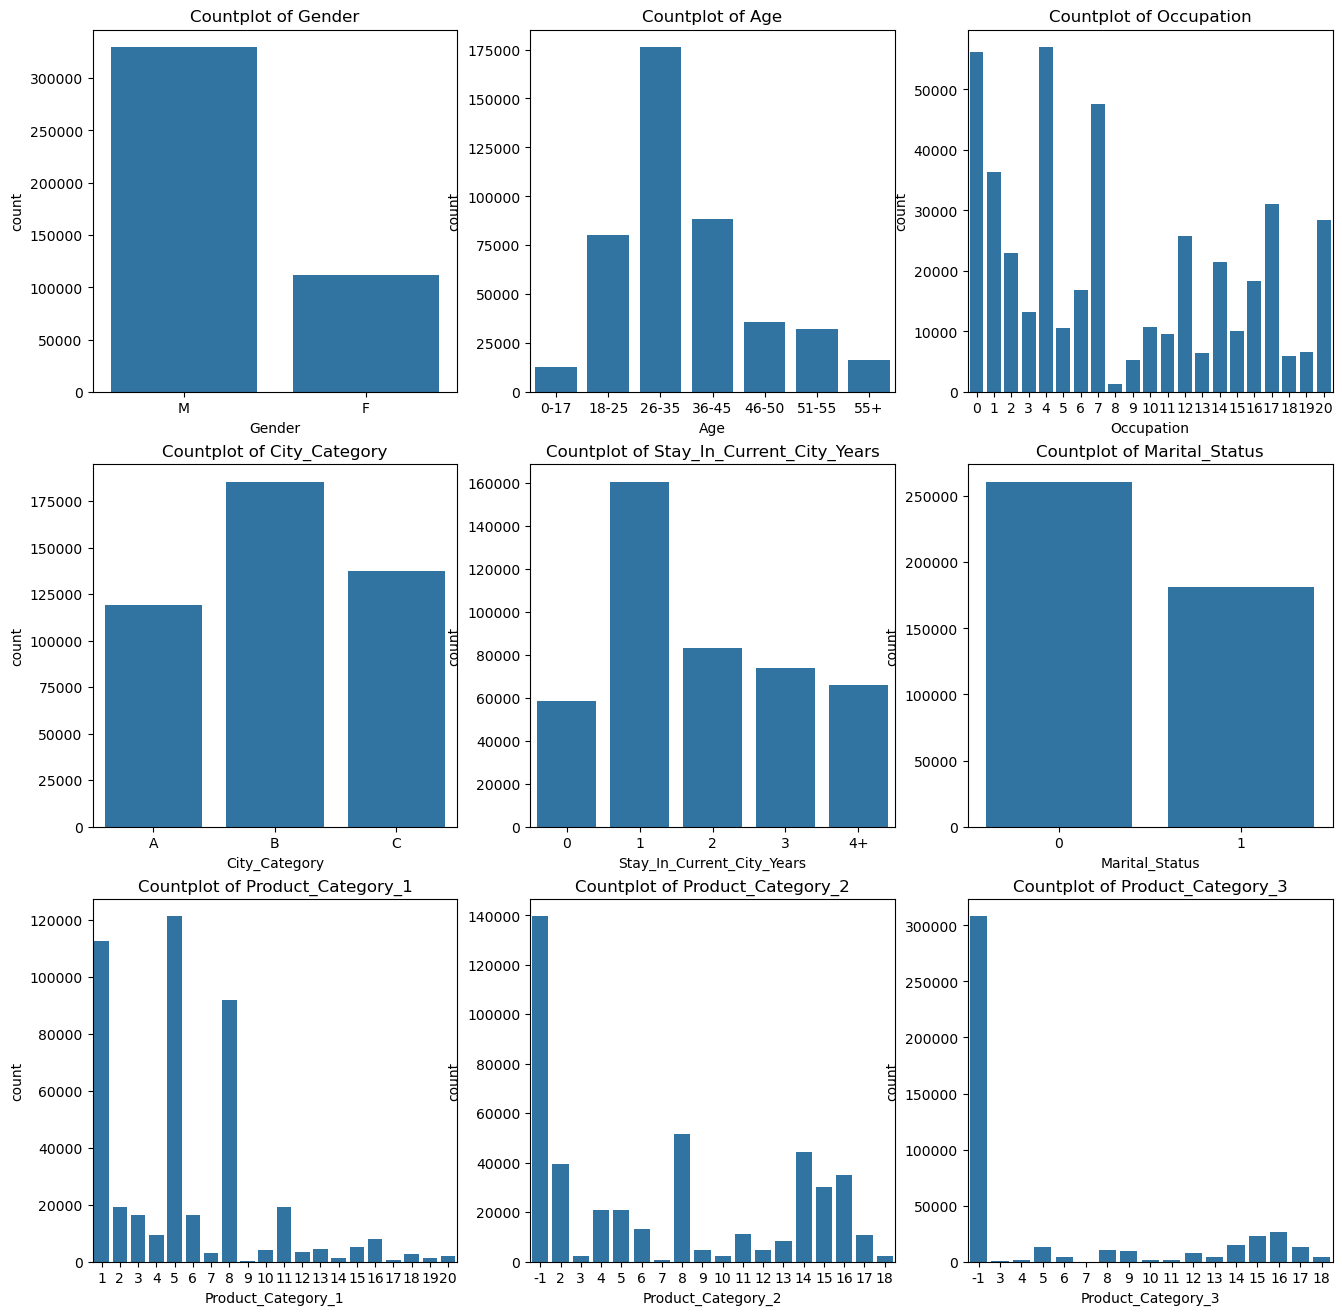

In [12]:
# Plotting count for each categorical variable

orders = [['M', 'F'],
          ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
          range(21),
          ['A', 'B', 'C'],
          ['0', '1', '2', '3', '4+'],
          [0, 1],
          range(1, 21),
          [-1] + list(range(2, 19)),
          [-1] + list(range(3, 19))]

fig, axs = plt.subplots(3, 3, figsize=(16,16))
for i, col in enumerate(['Gender', 'Age', 'Occupation',
            'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status',
            'Product_Category_1', 'Product_Category_2', 'Product_Category_3']):
    ax = axs[i//3, i%3]
    sns.countplot(x=col, data=df, ax=ax, order=orders[i])
    ax.title.set_text(f'Countplot of {col}')
plt.show()

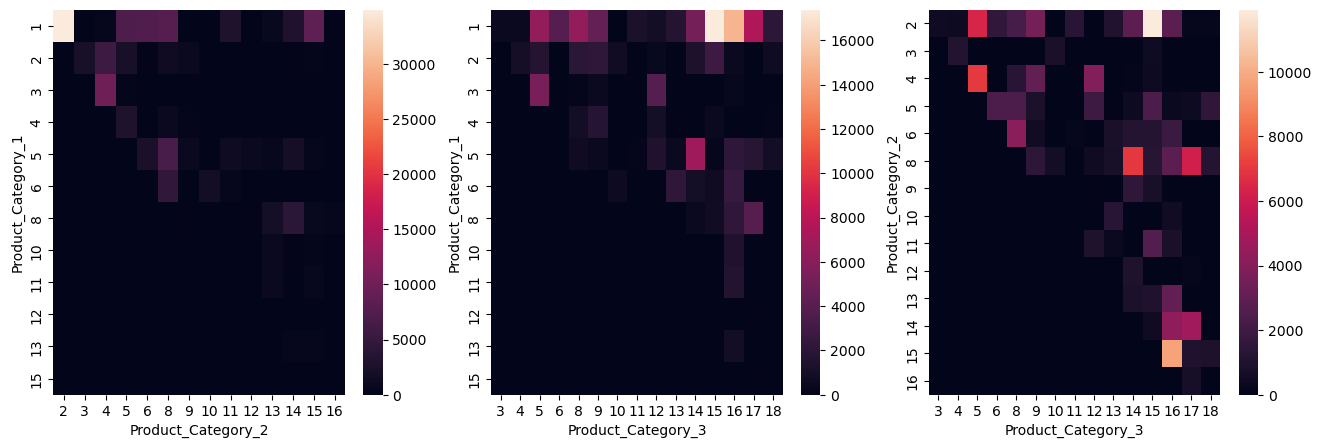

In [13]:
# Heatmap of Product Categories

fig, axs = plt.subplots(1, 3, figsize=(16,5))
mask = (df['Product_Category_3'] != -1) | ((df['Product_Category_3'] != -1))
sns.heatmap(df[mask].groupby(['Product_Category_1', 'Product_Category_2']).size().unstack(fill_value=0), ax=axs[0])
sns.heatmap(df[mask].groupby(['Product_Category_1', 'Product_Category_3']).size().unstack(fill_value=0), ax=axs[1])
sns.heatmap(df[mask].groupby(['Product_Category_2', 'Product_Category_3']).size().unstack(fill_value=0), ax=axs[2])
plt.show()

In [14]:
# Grouping by user ("User_ID")

users = pd.DataFrame()
users['Gender'] = df.groupby('User_ID').agg({'Gender': 'first'})
users['Age'] = df.groupby('User_ID').agg({'Age': 'first'})
users['Occupation'] = df.groupby('User_ID').agg({'Occupation': 'first'})
users['City_Category'] = df.groupby('User_ID').agg({'City_Category': 'first'})
users['Stay_In_Current_City_Years'] = df.groupby('User_ID').agg({'Stay_In_Current_City_Years': 'first'})
users['Marital_Status'] = df.groupby('User_ID').agg({'Marital_Status': 'first'})
users['Number of Purchases'] = df.groupby('User_ID').size()
users['Sum spent'] = df.groupby('User_ID')['Purchase'].sum()
users['Average Purchase'] = df.groupby('User_ID')['Purchase'].mean()
users=users.sort_values(by='Sum spent', ascending=False)
users

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Number of Purchases,Sum spent,Average Purchase
User_ID,,,,,,,,,
1001680,M,26-35,20,A,3,1,1026,8699596,8479.138402
1002909,M,26-35,7,A,1,0,718,7577756,10553.977716
1001941,M,36-45,17,A,1,0,898,6817493,7591.863029
1004448,M,26-35,14,A,0,0,575,6566245,11419.556522
1005831,M,26-35,1,A,2,1,727,6512433,8957.954608
...,...,...,...,...,...,...,...,...,...
1004991,F,55+,14,C,3,1,7,52371,7481.571429
1005117,F,26-35,0,B,0,0,9,49668,5518.666667
1003883,M,51-55,16,C,2,1,9,49349,5483.222222


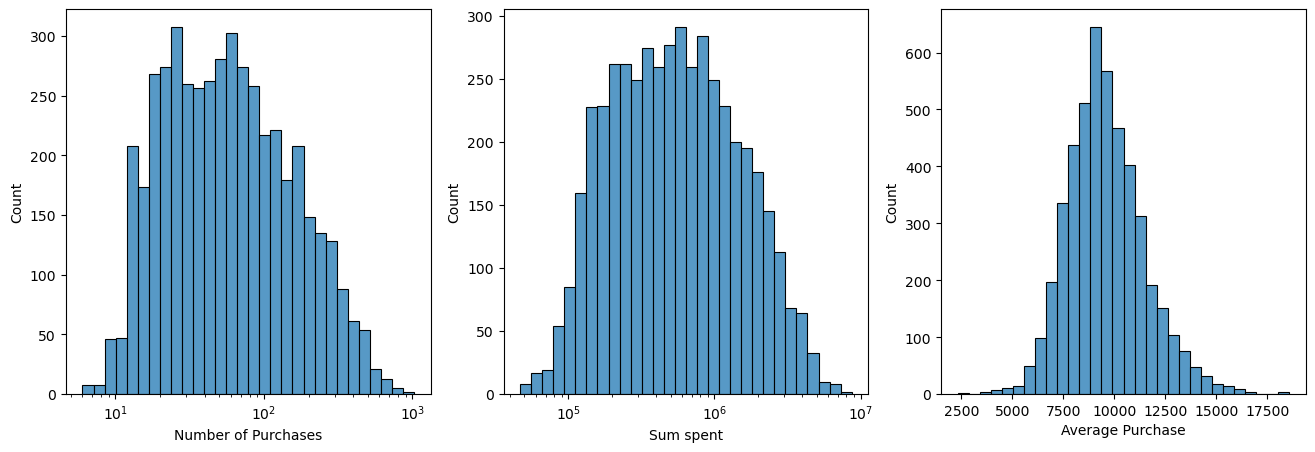

In [15]:
# Plotting "Number of Purchases", "Sum spent" and "Average Purchase" by user
## "Number of Purchases" and "Sum spent" plots are in log-scale

fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(x=users['Number of Purchases'], bins=30, ax=axs[0], log_scale=True)#, hue=users['Age'], multiple='stack')
sns.histplot(x=users['Sum spent'], bins=30, ax=axs[1], log_scale=True)#, hue=users['Age'], multiple='stack')
sns.histplot(x=users['Average Purchase'], bins=30, ax=axs[2])#, hue=users['Age'], multiple='stack')
plt.show()

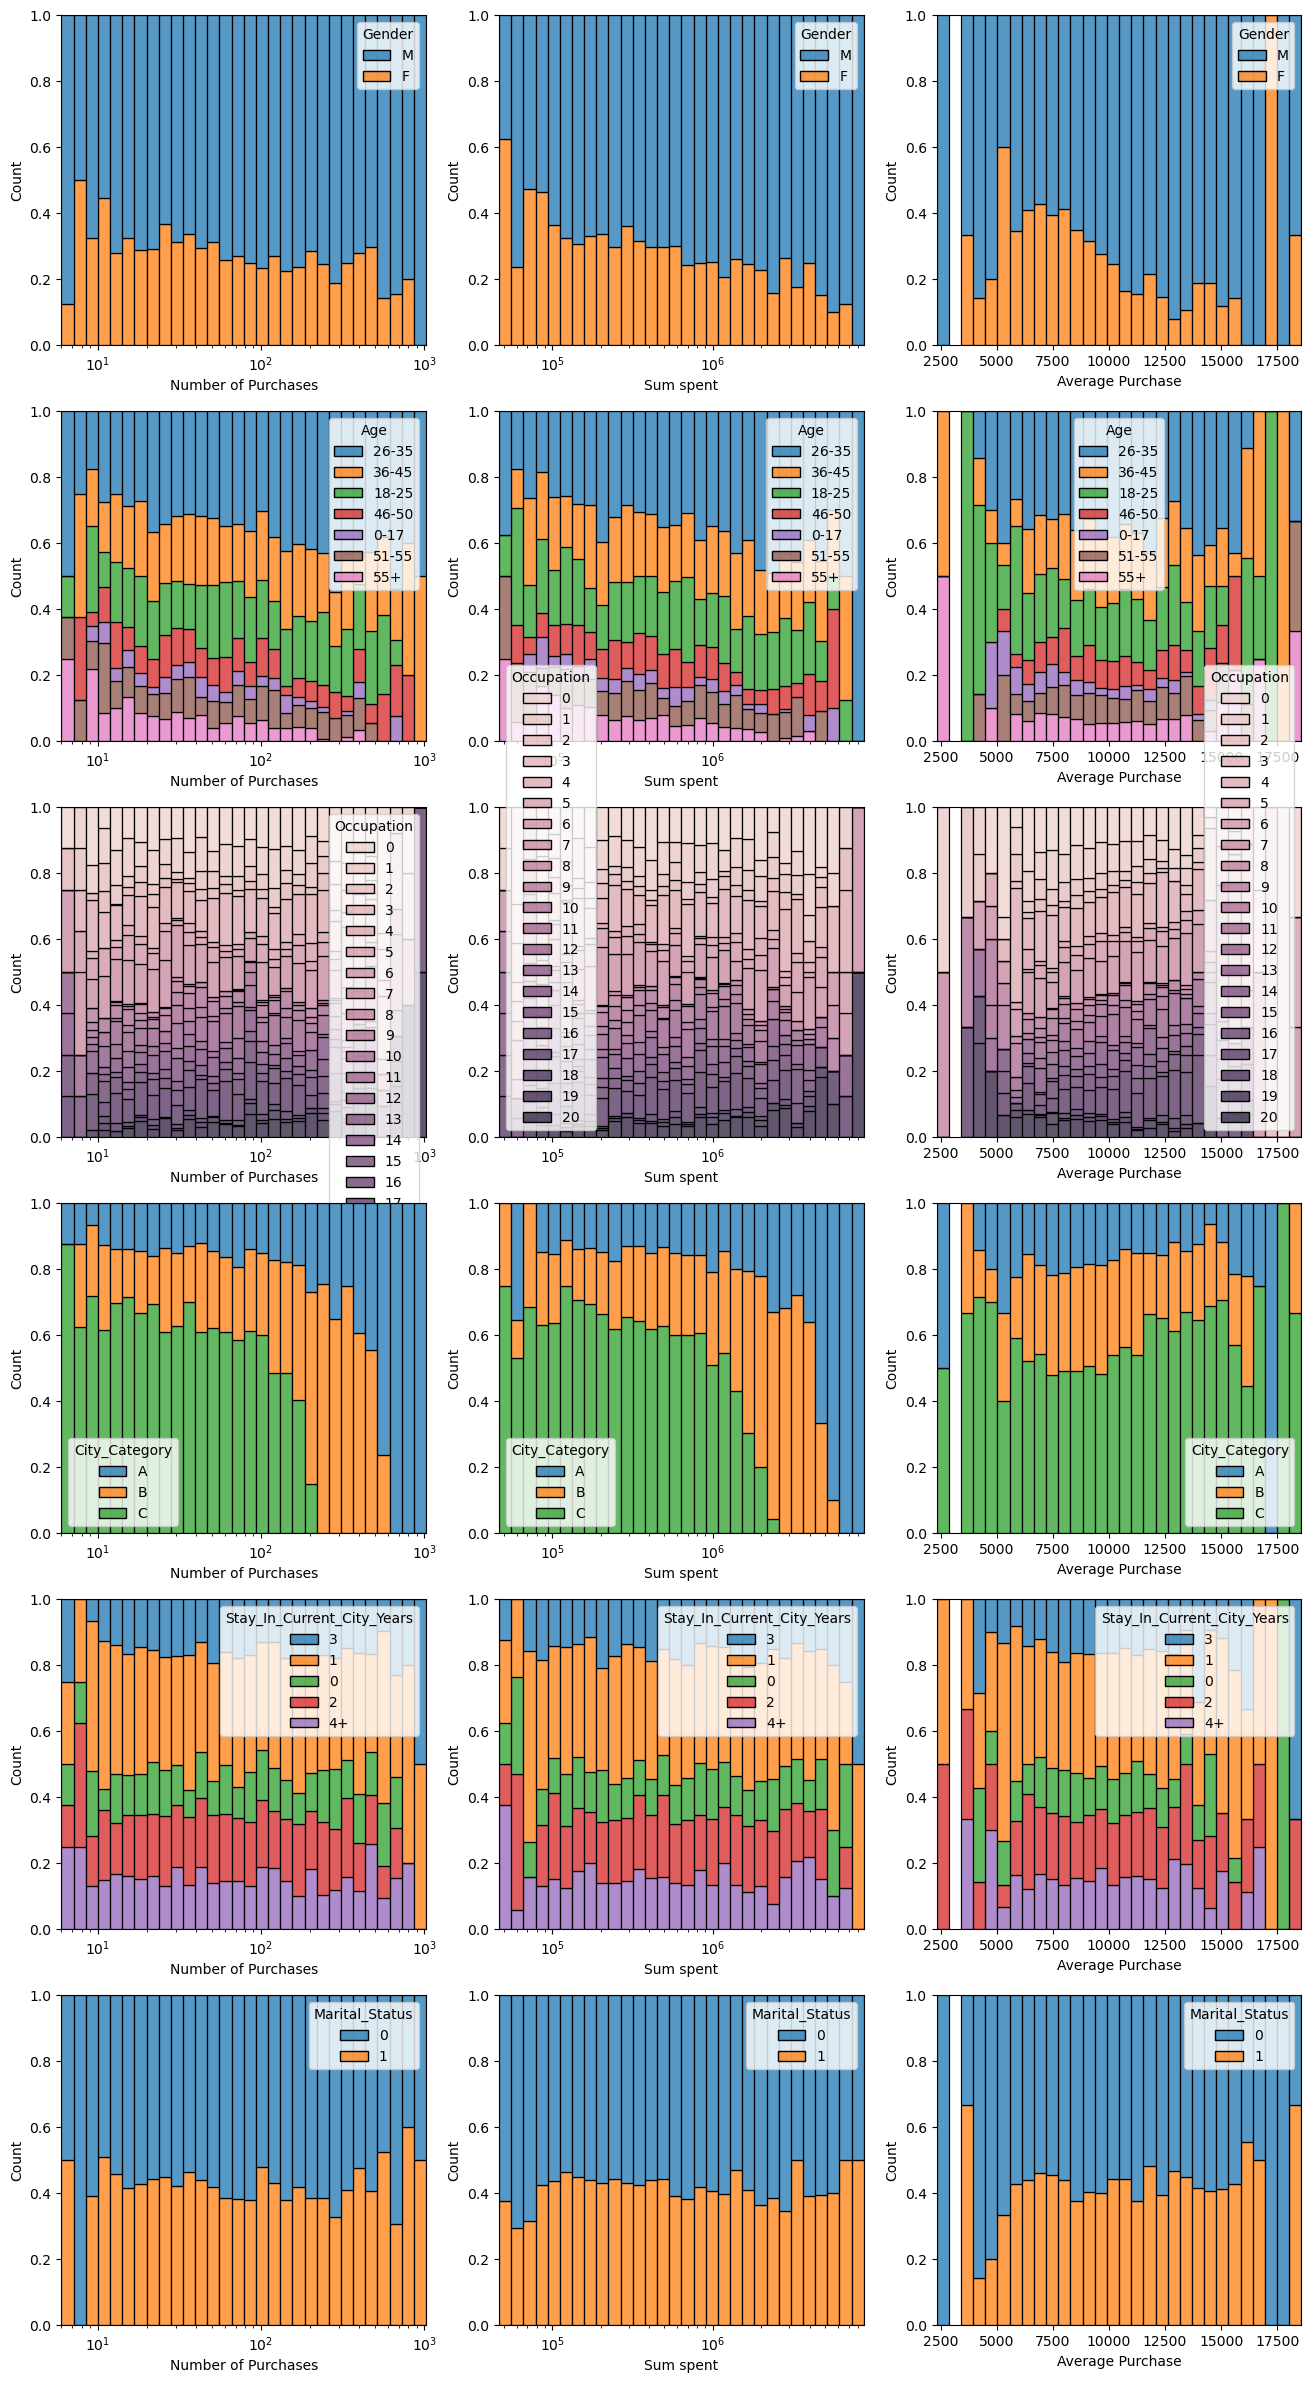

In [16]:
# Plotting "Number of Purchases", "Sum spent" and "Average Purchase" by user charcteristics
## "Number of Purchases" and "Sum spent" plots are in log-scale
## histograms are filled to see the percentage of each group in each bin

fig, axs = plt.subplots(6, 3, figsize=(16,30))
for i,col in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    sns.histplot(x=users['Number of Purchases'], bins=30, ax=axs[i, 0], log_scale=True, hue=users[col], multiple='fill')
    sns.histplot(x=users['Sum spent'], bins=30, ax=axs[i, 1], log_scale=True, hue=users[col], multiple='fill')
    sns.histplot(x=users['Average Purchase'], bins=30, ax=axs[i, 2], hue=users[col], multiple='fill')
plt.show()

In [17]:
# Grouping by product ("Product_ID")

prods=pd.DataFrame()
prods['Product_Category_1'] = df.groupby('Product_ID').agg({'Product_Category_1': 'first'})
prods['Number of Purchases'] = df.groupby('Product_ID').size()
prods['Sum spent'] = df.groupby('Product_ID')['Purchase'].sum()
prods['Unitary Price'] = prods['Sum spent'] / prods['Number of Purchases']
prods=prods.sort_values(by='Sum spent', ascending=False)
prods

,Product_Category_1,Number of Purchases,Sum spent,Unitary Price
Product_ID,,,,
P00025442,1,1312,22837010,17406.257622
P00110742,1,1283,21326433,16622.317225
P00255842,16,1103,20070184,18195.996374
P00059442,6,1154,19957844,17294.492201
P00112142,1,1278,19864377,15543.330986
...,...,...,...,...
P00281342,11,1,1609,1609.000000
P00353042,11,1,1545,1545.000000
P00063242,13,2,962,481.000000


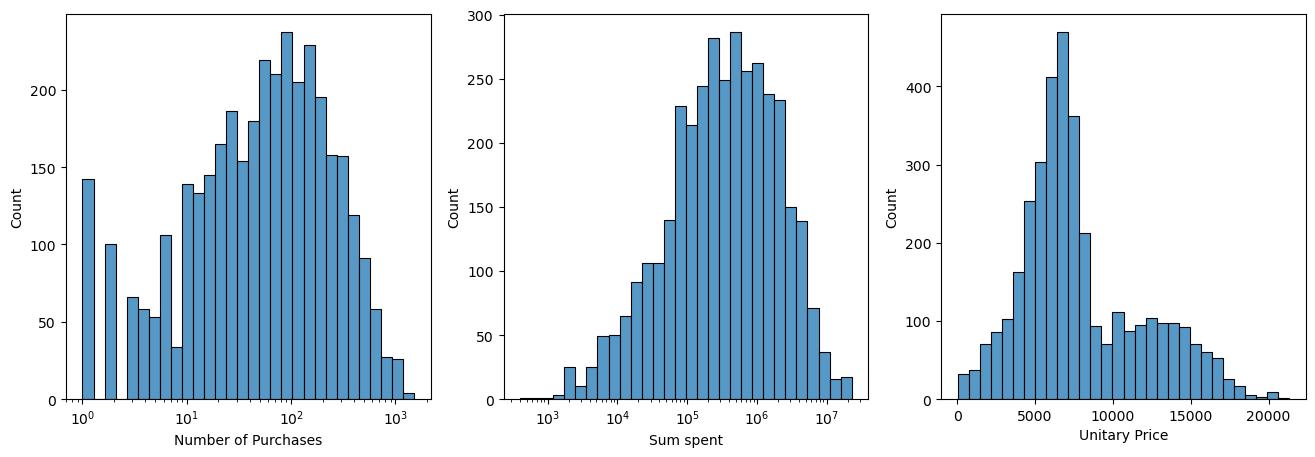

In [18]:
# Plotting "Number of Purchases", "Sum spent" and "Unitary Price" by product
## "Number of Purchases" and "Sum spent" plots are in log-scale

fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(x=prods['Number of Purchases'], bins=30, ax=axs[0], log_scale=True)#, hue=prods['Product_Category_1'], multiple='stack')
sns.histplot(x=prods['Sum spent'], bins=30, ax=axs[1], log_scale=True)#, hue=prods['Product_Category_1'], multiple='stack')
sns.histplot(x=prods['Unitary Price'], bins=30, ax=axs[2])#, hue=prods['Product_Category_1'], multiple='stack')
plt.show()

In [19]:
# Grouping by product category ("Product_Category_1")

prods_cat=pd.DataFrame()
prods_cat['Number of Purchases'] = df.groupby('Product_Category_1').size()
prods_cat['Sum spent'] = df.groupby('Product_Category_1')['Purchase'].sum()
prods_cat['Average Price'] = prods_cat['Sum spent'] / prods_cat['Number of Purchases']
prods_cat=prods_cat.sort_values(by='Sum spent', ascending=False)
prods_cat

,Number of Purchases,Sum spent,Average Price
Product_Category_1,,,
1,112633,1535757040,13635.054025
5,121165,756192449,6241.013898
8,91691,687833781,7501.649900
6,16509,261189641,15821.045551
2,19171,216173151,11276.049815
3,16344,165230339,10109.541055
16,7949,117422607,14771.997358
11,19290,90698878,4701.859927
10,4145,81665547,19702.182630


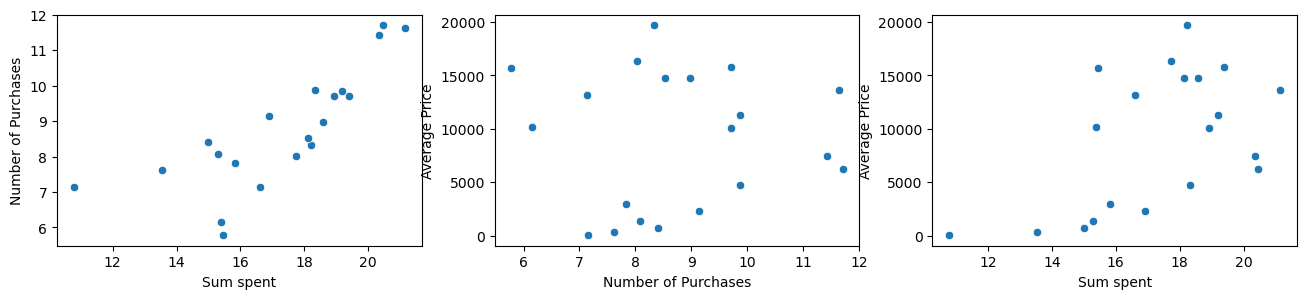

In [20]:
# Plotting "Number of Purchases", "Sum spent" and "Average Price" by product category
## "Number of Purchases" and "Sum spent" plots are in log-scale

fig, axs = plt.subplots(1, 3, figsize=(16,3))
sns.scatterplot(x=np.log(prods_cat['Sum spent']), y=np.log(prods_cat['Number of Purchases']), ax=axs[0])
sns.scatterplot(x=np.log(prods_cat['Number of Purchases']), y='Average Price', data=prods_cat, ax=axs[1])
sns.scatterplot(x=np.log(prods_cat['Sum spent']), y='Average Price', data=prods_cat, ax=axs[2])
plt.show()

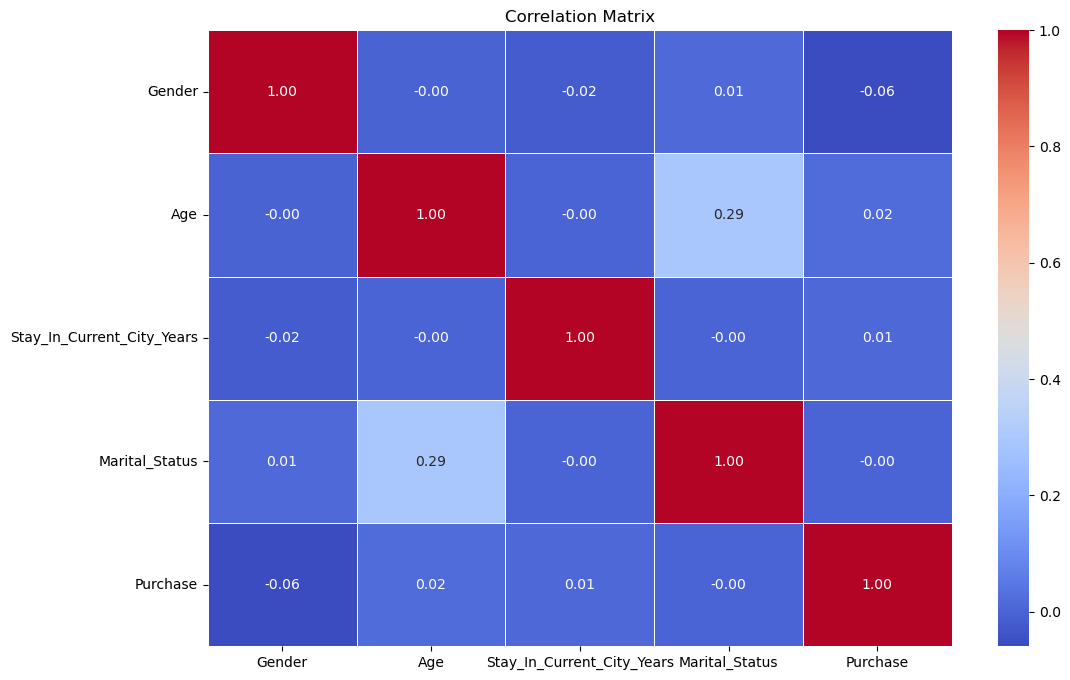

In [21]:
# Studing correlation between variables

df_numerical = deepcopy(df)
df_numerical = df_numerical[['Gender', 'Age', 'Stay_In_Current_City_Years', 'Marital_Status', 'Purchase']]

df_numerical['Gender'] = [0 if x=='M' else 1 for x in df_numerical['Gender']]
df_numerical['Age'] = ['55-95' if x=='55+' else x for x in df_numerical['Age']]
df_numerical['Age'] = [np.mean([int(x.split('-')[0]), int(x.split('-')[-1])])for x in df_numerical['Age']]
df_numerical['Stay_In_Current_City_Years'] = [int(x[:-1]) if x=='4+' else int(x) for x in df_numerical['Stay_In_Current_City_Years']]

correlation_matrix = df_numerical.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [22]:
# Grouping by user category ("Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status")

user_groups=pd.DataFrame()
grouping_cols = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
user_groups['Numerosity'] = users.groupby(grouping_cols).size()
user_groups['log_Numerosity'] = np.log(user_groups['Numerosity'])
user_groups['Sum spent'] = users.groupby(grouping_cols)['Sum spent'].sum()
user_groups['log_SumSpent'] = np.log(user_groups['Sum spent'])
user_groups['Average Purchase'] = users.groupby(grouping_cols)['Average Purchase'].mean()
user_groups=user_groups.sort_values(by='Sum spent', ascending=False)
user_groups

Numerosity  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status               
M      18-25 4          B             4+                         0                       17   
                                      1                          0                       23   
       26-35 7          A             1                          0                       14   
       18-25 4          B             2                          0                       12   
       26-35 0          B             1                          0                       10   
...                                                                                     ...   
F      46-50 2          C             2                          0                        1   
       36-45 9          C             2                          1                        1   
M      18-25 2          B             2                          1                        1   
F      18-25 10         C             4+                         0                        1   
       55+   14         C             3                          1                        1   

                                                                                 log_Numerosity  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status                   
M      18-25 4          B             4+                         0                     2.833213   
                                      1                          0                     3.135494   
       26-35 7          A             1                          0                     2.639057   
       18-25 4          B             2                          0                     2.484907   
       26-35 0          B             1                          0                     2.302585   
...                                                                                         ...   
F      46-50 2          C             2                          0                     0.000000   
       36-45 9          C             2                          1                     0.000000   
M      18-25 2          B             2                          1                     0.000000   
F      18-25 10         C             4+                         0                     0.000000   
       55+   14         C             3                          1                     0.000000   

                                                                                 Sum spent  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status              
M      18-25 4          B             4+                         0                26510595   
                                      1                          0                24294633   
       26-35 7          A             1                          0                23853765   
       18-25 4          B             2                          0                18538981   
       26-35 0          B             1                          0                16295829   
...                                                                                    ...   
F      46-50 2          C             2                          0                   62250   
       36-45 9          C             2                          1                   61972   
M      18-25 2          B             2                          1                   57805   
F      18-25 10         C             4+                         0                   53996   
       55+   14         C             3                          1                   52371   

                                                                                 log_SumSpent  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status                 
M      18-25 4          B             4+                         0                  17.093055   
                                      1    

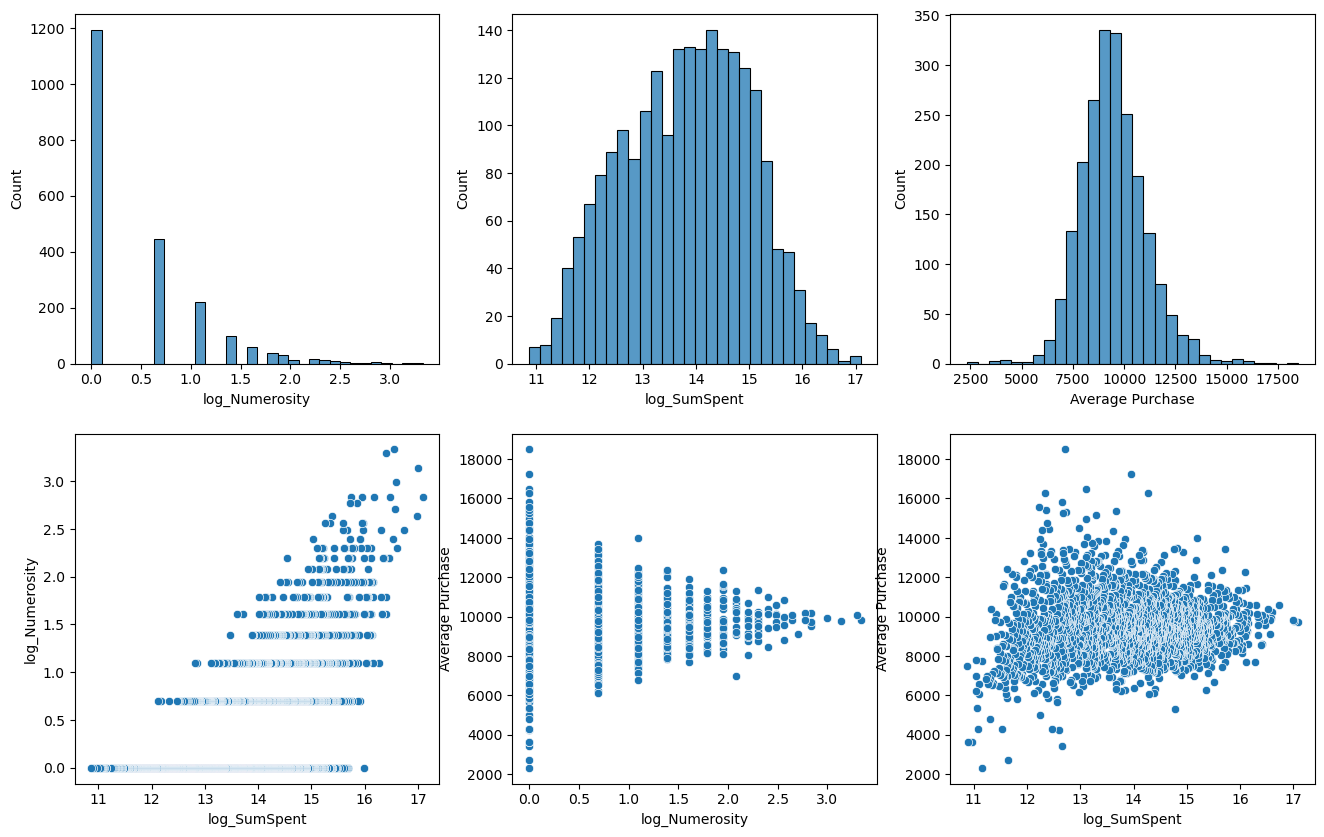

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))
sns.histplot(x=user_groups['log_Numerosity'], bins='auto', ax=axs[0,0])
sns.histplot(x=user_groups['log_SumSpent'], bins=30, ax=axs[0,1])
sns.histplot(x=user_groups['Average Purchase'], bins=30, ax=axs[0,2])
sns.scatterplot(x='log_SumSpent', y='log_Numerosity', data=user_groups, ax=axs[1,0])
sns.scatterplot(x='log_Numerosity', y='Average Purchase', data=user_groups, ax=axs[1,1])
sns.scatterplot(x='log_SumSpent', y='Average Purchase', data=user_groups, ax=axs[1,2])
plt.show()

# Data preprocessing
We have seen that the users that spends the most (in total) are the ones that buy a lot of products with average prices. At the same time, the products more profitable have the same features, lots of purchases and an average price.

In [24]:
# Dividing "big-spenders" from the rest

threshold = np.quantile(users['Sum spent'], 0.70, axis=0)
print(f'The big-spender threshold is set at {threshold}, that is the 0.9 quantile for "Sum spent".')

users['is_BigSpender'] = (users['Sum spent'] >= threshold).astype(int)
users

The big-spender threshold is set at 946918.7, that is the 0.9 quantile for "Sum spent".


,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Number of Purchases,Sum spent,Average Purchase,is_BigSpender
User_ID,,,,,,,,,,
1001680,M,26-35,20,A,3,1,1026,8699596,8479.138402,1
1002909,M,26-35,7,A,1,0,718,7577756,10553.977716,1
1001941,M,36-45,17,A,1,0,898,6817493,7591.863029,1
1004448,M,26-35,14,A,0,0,575,6566245,11419.556522,1
1005831,M,26-35,1,A,2,1,727,6512433,8957.954608,1
...,...,...,...,...,...,...,...,...,...,...
1004991,F,55+,14,C,3,1,7,52371,7481.571429,0
1005117,F,26-35,0,B,0,0,9,49668,5518.666667,0
1003883,M,51-55,16,C,2,1,9,49349,5483.222222,0


In [25]:
# Dividing BigSpender in the test set

users_test['is_BigSpender'] = (users_test['Sum spent'] >= threshold).astype(int)
users_test

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Number of Purchases,Sum spent,Average Purchase,is_BigSpender
User_ID,,,,,,,,,,
1005452,M,36-45,6,A,4+,0,162,1485500,9169.753086,1
1005543,M,26-35,17,A,2,0,190,1891121,9953.268421,1
1005881,M,36-45,17,B,1,0,159,1415078,8899.861635,1
1001531,M,46-50,17,C,2,1,19,144107,7584.578947,0
1004180,M,55+,13,C,1,1,54,531531,9843.166667,0
...,...,...,...,...,...,...,...,...,...,...
1002041,F,26-35,20,B,4+,0,312,2499908,8012.525641,1
1003846,M,36-45,0,C,0,0,36,302041,8390.027778,0
1004301,M,36-45,11,C,1,1,18,198664,11036.888889,0


In [26]:
# Selecting "regression" or "classification"

model_type = "classification"

assert(model_type in ["regression", "classification"])

In [27]:
# Dropping useless columns

users.drop(['Number of Purchases', 'Average Purchase'], axis=1, inplace=True)
users_test.drop(['Number of Purchases', 'Average Purchase'], axis=1, inplace=True)

if model_type == "regression":
    users.drop(['is_BigSpender'], axis=1, inplace=True)
    users_test.drop(['is_BigSpender'], axis=1, inplace=True)
    y_col = 'Sum spent'
else:
    users.drop(['Sum spent'], axis=1, inplace=True)
    users_test.drop(['Sum spent'], axis=1, inplace=True)
    y_col = 'is_BigSpender'

In [28]:
# Separating "X" and "y"

X_train = users.drop(y_col, axis=1)
y_train = users[y_col]

X_test = users_test.drop(y_col, axis=1)
y_test = users_test[y_col]

In [29]:
# Encoding categorical columns

for column in X_train.columns:
    if X_train[column].dtype == 'object':
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column])
        X_test[column] = label_encoder.transform(X_test[column])

# Training

In [30]:
# def objective(trial):
#     # Defining the hyperparameters to search over
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 5,100),
#         'max_depth': trial.suggest_int('max_depth', 2, 20),
#         # 'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1),
#         # 'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
#         # 'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
#     }

#     # Evaluating the Random Forest model with the current set of hyperparameters
#     if model_type == "regression":
#         model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
#         metric = r2_score
#     else:
#         model = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
#         metric = f1_score
    
#     random.seed(42)

    # train_idx = random.sample(list(X_train.index), round(X_train.shape[0] * 4/5))
    # valid_idx = list(set(X_train.index) - set(train_idx))
    # model.fit(X_train.loc[train_idx], y_train.loc[train_idx], )
    # y_pred = model.predict(X_train.loc[valid_idx])
    # score_valid = metric(y_train.loc[valid_idx], y_pred)
    # print(score_valid)
    # return score_valid
#     # scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
#     # return scores.mean()

# # Creating a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Printing the best hyperparameters and corresponding accuracy
# print('Best Trial:')
# print('  Value: ', study.best_trial.value)
# print('  Params: ')
# for key, value in study.best_trial.params.items():
#     print(f'    {key}: {value}')

In [31]:
def objective(trial):
    # Defining the hyperparameters to search over
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5,1000),
        'num_leaves': trial.suggest_int('max_depth', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
    }

    # Evaluating the Random Forest model with the current set of hyperparameters
    if model_type == "regression":
        model = LGBMRegressor(**params, n_jobs=-1, random_state=42)
        metric = r2_score
    else:
        model = LGBMClassifier(**params, n_jobs=-1, random_state=42)
        metric = recall_score
    
    random.seed(42)

    train_idx = random.sample(list(X_train.index), round(X_train.shape[0] * 4/5))
    valid_idx = list(set(X_train.index) - set(train_idx))
    model.fit(X_train.loc[train_idx], y_train.loc[train_idx], )
    y_pred = model.predict(X_train.loc[valid_idx])
    score_valid = metric(y_train.loc[valid_idx], y_pred)
    print(score_valid)
    return score_valid
    # scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
    # return scores.mean()

# Creating a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

# Printing the best hyperparameters and corresponding accuracy
print('Best Trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-29 15:28:49,720] A new study created in memory with name: no-name-654663f3-7a01-43ea-bf7a-fbe9bc3de41a


[LightGBM] [Info] Number of positive: 1135, number of negative: 2635

c:\Users\enric\anaconda3\envs\gcp_demo2\Lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 10, 'high': 50}
  warnings.warn(



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 3770, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301061 -> initscore=-0.842251
[LightGBM] [Info] Start training from score -0.842251


[I 2023-11-29 15:28:50,123] Trial 0 finished with value: 0.33691756272401435 and parameters: {'n_estimators': 311, 'max_depth': 29}. Best is trial 0 with value: 0.33691756272401435.


0.33691756272401435
Best Trial:
  Value:  0.33691756272401435
  Params: 
    n_estimators: 311
    max_depth: 29


In [32]:
seed = 42

if model_type == "regression":
    model = LGBMRegressor(**study.best_trial.params, n_jobs=-1, random_state=seed)
    metric = r2_score
else:
    model = LGBMClassifier(**study.best_trial.params, n_jobs=-1, random_state=seed)
    metric = recall_score
# model = LGBMClassifier(n_estimators=10000, n_jobs=-1, random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
score_train = metric(y_train, y_pred)
score_train

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1414, number of negative: 3298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 4712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300085 -> initscore=-0.846894
[LightGBM] [Info] Start training from score -0.846894
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.5396039603960396

In [33]:
metric.__name__.split('_')[0]

'recall'

In [34]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric.__name__.split('_')[0])
print(scores)
scores.mean()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1131, number of negative: 2638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 3769, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300080 -> initscore=-0.846919
[LightGBM] [Info] Start training from score -0.846919
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't 

0.3358394105706338

# Testing

In [35]:
score_test = metric(y_test, model.predict(X_test))
score_test

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.35260115606936415

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


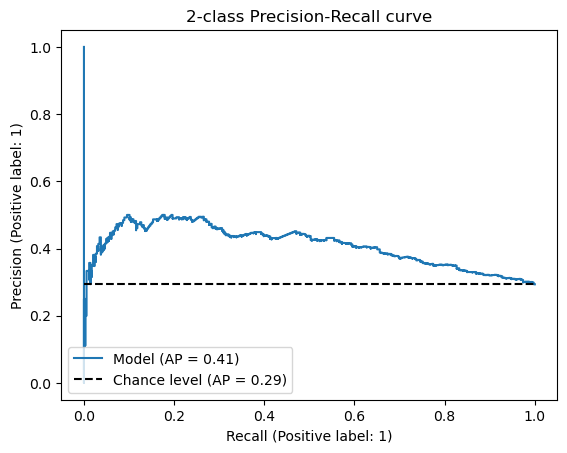

In [36]:
if model_type == "classification":
    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, name="Model", plot_chance_level=True
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

In [37]:
print(
f"""Accuracy: {accuracy_score(y_test, model.predict(X_test))}
Precision: {precision_score(y_test, model.predict(X_test))}
Recall: {recall_score(y_test, model.predict(X_test))}""")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.6768447837150128
Precision: 0.43727598566308246
Recall: 0.35260115606936415
